# Modelagem - Machine Learning

## Objetivos

Este notebook realiza o treinamento de múltiplos modelos de Machine Learning para a detecção de ataques cibernéticos. Para isso,
será feita a separação dos dados em treino e teste, seguida pelo treinamento e avaliação de diferentes algoritmos.

## Bibliotecas e Importações

In [2]:
# Manipulação e plotagem dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Padronização do formato dos dados
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Validação cruzada
from sklearn.model_selection import cross_val_score

# Divisão em Features(X) e Target(y)
from sklearn.model_selection import train_test_split

# Classificação Binária
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Classificação Multiclasse
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Avaliação e comparação dos modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            accuracy_score, precision_score, \
                            f1_score, classification_report, \
                            precision_recall_curve, \
                            roc_auc_score, roc_curve, auc

## Carregamento dos dados

In [3]:
path_2017 = r"C:\Users\augus\Capstone-Data-Science-Project\dados\feature\IDS-2017-FEATURE.csv"
path_2018_1 = r"C:\Users\augus\Capstone-Data-Science-Project\dados\feature\IDS-2018-1-FEATURE.csv"
path_2018_2 = r"C:\Users\augus\Capstone-Data-Science-Project\dados\feature\IDS-2018-2-FEATURE.csv"
path_2018_3 = r"C:\Users\augus\Capstone-Data-Science-Project\dados\feature\IDS-2018-3-FEATURE.csv"

df_2017 = pd.read_csv(path_2017)
df_2018_1 = pd.read_csv(path_2018_1)
df_2018_2 = pd.read_csv(path_2018_2)
df_2018_3 = pd.read_csv(path_2018_3)

##### Reduzindo memória

In [5]:
def reduzir_mem(data):
    memoria_inicial = data.memory_usage().sum() / 1024 ** 2
    print(f'Uso inicial de memória: {memoria_inicial:.2f} MB')

    for col in data.columns:
        col_type = data[col].dtype
        if str(col_type).find('float') >= 0:  # Se for tipo float
            c_min = data[col].min()
            c_max = data[col].max()
            
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                data[col] = data[col].astype(np.float32)
    
        elif str(col_type).find('int') >= 0:  # Se for tipo int
            c_min = data[col].min()
            c_max = data[col].max()
            
            if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                data[col] = data[col].astype(np.int32)

    # Calculando o uso final de memória
    memoria_final = data.memory_usage().sum() / 1024 ** 2
    print(f'Uso final de memória: {memoria_final:.2f} MB')

In [6]:
dados = {
    "IDS-2017-FEATURE": df_2017,
    "IDS-2018-1-FEATURE": df_2018_1,
    "IDS-2018-2-FEATURE": df_2018_2,
    "IDS-2018-3-FEATURE": df_2018_3
}

for nome, df in dados.items():
    print(f"\nReduzindo memória do {nome}...")
    reduzir_mem(df)


Reduzindo memória do IDS-2017-FEATURE...
Uso inicial de memória: 1366.33 MB
Uso final de memória: 712.03 MB

Reduzindo memória do IDS-2018-1-FEATURE...
Uso inicial de memória: 1669.59 MB
Uso final de memória: 929.90 MB

Reduzindo memória do IDS-2018-2-FEATURE...
Uso inicial de memória: 1881.87 MB
Uso final de memória: 1048.13 MB

Reduzindo memória do IDS-2018-3-FEATURE...
Uso inicial de memória: 1194.07 MB
Uso final de memória: 604.59 MB


## Classificação Binária

#### Criando dataset balanceado ✅

In [18]:
# Função para balancear os datasets
def balancear_binaria(df, n_amostras=15000):
    trafego_benigno = df[df['Tipos de Ataques'].isin(['BENIGN', 'Benign'])]
    trafego_malicioso = df[~df['Tipos de Ataques'].isin(['BENIGN', 'Benign'])]

    trafego_benigno = trafego_benigno.sample(n=len(trafego_malicioso), replace=False)

    benigno_sample = trafego_benigno.sample(n=len(trafego_benigno), random_state=42)
    malicioso_sample = trafego_malicioso.sample(n=len(trafego_malicioso), random_state=42)

    df_provisorio = pd.concat([benigno_sample, malicioso_sample])
    df_provisorio['Tipos de Ataques'] = df_provisorio['Tipos de Ataques'].apply(lambda x: 0 if x in ['BENIGN', 'Benign'] else 1)

    return df_provisorio.sample(n=n_amostras, random_state=42)

In [20]:
# Executando a função
df_2017_balanceado = balancear_binaria(df_2017)
df_2018_1_balanceado = balancear_binaria(df_2018_1)
df_2018_2_balanceado = balancear_binaria(df_2018_2)
df_2018_3_balanceado = balancear_binaria(df_2018_3)

In [21]:
datasets = {
    "IDS-2017-BLCD": df_2017_balanceado,
    "IDS-2018-1-BLCD": df_2018_1_balanceado,
    "IDS-2018-2-BLCD": df_2018_2_balanceado,
    "IDS-2018-3-BLCD": df_2018_3_balanceado
}

for nome, df in datasets.items():
    print(f"Distribuição - {nome}:")
    print(f'{df['Tipos de Ataques'].value_counts()}')
    print(f'{'-' * 40}')

Distribuição - IDS-2017-BLCD:
Tipos de Ataques
0    7539
1    7461
Name: count, dtype: int64
----------------------------------------
Distribuição - IDS-2018-1-BLCD:
Tipos de Ataques
0    7575
1    7425
Name: count, dtype: int64
----------------------------------------
Distribuição - IDS-2018-2-BLCD:
Tipos de Ataques
0    7552
1    7448
Name: count, dtype: int64
----------------------------------------
Distribuição - IDS-2018-3-BLCD:
Tipos de Ataques
0    7511
1    7489
Name: count, dtype: int64
----------------------------------------


#### Separação dos Dados ✅

In [24]:
# Separando os dados em Recursos (X) e Alvos (y)
scaler_bin = StandardScaler()

X_2017_bin = df_2017_balanceado.drop('Tipos de Ataques', axis=1)
y_2017_bin = df_2017_balanceado['Tipos de Ataques']

X_2017_bin_scaled = scaler_bin.fit_transform(X_2017_bin)

X_train_2017_bin, X_test_2017_bin, y_train_2017_bin, y_test_2017_bin = train_test_split(X_2017_bin_scaled, y_2017_bin, test_size=0.25, random_state=0)

In [26]:
# Separando os dados em Recursos (X) e Alvos (y)
X_2018_1_bin = df_2018_1_balanceado.drop('Tipos de Ataques', axis=1)
y_2018_1_bin = df_2018_1_balanceado['Tipos de Ataques']

cols_nao_num_2018_1_bin = X_2018_1_bin.select_dtypes(include=['object']).columns

X_2018_1_bin = X_2018_1_bin.drop(columns=cols_nao_num_2018_1_bin)
X_2018_1_bin_scaled = scaler_bin.fit_transform(X_2018_1_bin)

X_train_2018_1_bin, X_test_2018_1_bin, y_train_2018_1_bin, y_test_2018_1_bin = train_test_split(X_2018_1_bin_scaled, y_2018_1_bin, test_size=0.25, random_state=0)

In [28]:
# Separando os dados em Recursos (X) e Alvos (y)
X_2018_2_bin = df_2018_2_balanceado.drop('Tipos de Ataques', axis=1)
y_2018_2_bin = df_2018_2_balanceado['Tipos de Ataques']

cols_nao_num_2018_2_bin = X_2018_2_bin.select_dtypes(include=['object']).columns

X_2018_2_bin = X_2018_2_bin.drop(columns=cols_nao_num_2018_2_bin)
X_2018_2_bin_scaled = scaler_bin.fit_transform(X_2018_2_bin)

X_train_2018_2_bin, X_test_2018_2_bin, y_train_2018_2_bin, y_test_2018_2_bin = train_test_split(X_2018_2_bin_scaled, y_2018_2_bin, test_size=0.25, random_state=0)

In [30]:
# Separando os dados em Recursos (X) e Alvos (y)
X_2018_3_bin = df_2018_3_balanceado.drop('Tipos de Ataques', axis=1)
y_2018_3_bin = df_2018_3_balanceado['Tipos de Ataques']

cols_nao_num_2018_3_bin = X_2018_3_bin.select_dtypes(include=['object']).columns

X_2018_3_bin = X_2018_3_bin.drop(columns=cols_nao_num_2018_3_bin)
X_2018_3_bin_scaled = scaler_bin.fit_transform(X_2018_3_bin)

X_train_2018_3_bin, X_test_2018_3_bin, y_train_2018_3_bin, y_test_2018_3_bin = train_test_split(X_2018_3_bin_scaled, y_2018_3_bin, test_size=0.25, random_state=0)

#### 1 - Regressão Logística ✅

##### Modelo

In [32]:
def modelo_reg(nome, X_train, y_train, max_iter=10000, solver='sag', C=100, random_state=0):

    modelo_reg = LogisticRegression(max_iter=max_iter, solver=solver, C=C, random_state=random_state)
    modelo_reg.fit(X_train, y_train)

    val_cruzada_regLo = cross_val_score(modelo_reg, X_train, y_train, cv=5)

    print(f'Modelo de Regressão Logística - {nome}')
    print('-' * 60)
    print('Pontuações da validação cruzada por partes:')
    for i, score in enumerate(val_cruzada_regLo, start=1):
        print(f'Parte {i}: {score:.4f}')

    print(f'\nMédia da pontuação de validação cruzada: {val_cruzada_regLo.mean():.4f}')
    print(f'Mínima pontuação de validação cruzada: {val_cruzada_regLo.min():.4f}')
    print(f'Máxima pontuação de validação cruzada: {val_cruzada_regLo.max():.4f}')
    print('-' * 40)

    return modelo_reg

##### Dataset - 2017

In [36]:
modelo_reg_2017 = modelo_reg('IDS-2017-BLCD', X_train_2017_bin, y_train_2017_bin)

Modelo de Regressão Logística - IDS-2017-BLCD
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9551
Parte 2: 0.9547
Parte 3: 0.9511
Parte 4: 0.9444
Parte 5: 0.9493

Média da pontuação de validação cruzada: 0.9509
Mínima pontuação de validação cruzada: 0.9444
Máxima pontuação de validação cruzada: 0.9551
----------------------------------------


##### Dataset - 2018

In [37]:
modelo_reg_2018_1 = modelo_reg('IDS-2018-1-BLCD', X_train_2018_1_bin, y_train_2018_1_bin)

Modelo de Regressão Logística - IDS-2018-1-BLCD
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9964
Parte 2: 0.9964
Parte 3: 0.9951
Parte 4: 0.9969
Parte 5: 0.9969

Média da pontuação de validação cruzada: 0.9964
Mínima pontuação de validação cruzada: 0.9951
Máxima pontuação de validação cruzada: 0.9969
----------------------------------------


In [38]:
modelo_reg_2018_2 = modelo_reg('IDS-2018-2-BLCD', X_train_2018_2_bin, y_train_2018_2_bin)

Modelo de Regressão Logística - IDS-2018-2-BLCD
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9964
Parte 2: 0.9982
Parte 3: 0.9964
Parte 4: 0.9969
Parte 5: 0.9956

Média da pontuação de validação cruzada: 0.9967
Mínima pontuação de validação cruzada: 0.9956
Máxima pontuação de validação cruzada: 0.9982
----------------------------------------


In [39]:
modelo_reg_2018_3 = modelo_reg('IDS-2018-3-BLCD', X_train_2018_3_bin, y_train_2018_3_bin)

Modelo de Regressão Logística - IDS-2018-3-BLCD
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.7911
Parte 2: 0.7853
Parte 3: 0.7916
Parte 4: 0.7960
Parte 5: 0.8022

Média da pontuação de validação cruzada: 0.7932
Mínima pontuação de validação cruzada: 0.7853
Máxima pontuação de validação cruzada: 0.8022
----------------------------------------


#### 2 - Support Vector Machine ✅

##### Modelo

In [40]:
def modelo_svm(nome, X_train, y_train, kernel='rbf', C=1, gamma=0.1, random_state=0):

    modelo_svm = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_state, probability=True)
    modelo_svm.fit(X_train, y_train)
    
    val_cruzada_svm = cross_val_score(modelo_svm, X_train, y_train, cv=5)
    
    print(f'Modelo SVM - {nome}')
    print('-' * 60)
    print('Pontuações da validação cruzada por partes:')
    for i, score in enumerate(val_cruzada_svm, start=1):
        print(f'Parte {i}: {score:.4f}')
    
    print(f'\nMédia da pontuação de validação cruzada: {val_cruzada_svm.mean():.4f}')
    print(f'Mínima pontuação de validação cruzada: {val_cruzada_svm.min():.4f}')
    print(f'Máxima pontuação de validação cruzada: {val_cruzada_svm.max():.4f}')
    print('-' * 60)

    return modelo_svm

##### Dataset - 2017

In [41]:
modelo_svm_2017 = modelo_svm('IDS-2017-BLCD', X_train_2017_bin, y_train_2017_bin)

Modelo SVM - IDS-2017-BLCD
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9676
Parte 2: 0.9667
Parte 3: 0.9680
Parte 4: 0.9591
Parte 5: 0.9627

Média da pontuação de validação cruzada: 0.9648
Mínima pontuação de validação cruzada: 0.9591
Máxima pontuação de validação cruzada: 0.9680
------------------------------------------------------------


##### Dataset - 2018

In [42]:
modelo_svm_2018_1 = modelo_svm('IDS-2018-1-BLCD', X_train_2018_1_bin, y_train_2018_1_bin)

Modelo SVM - IDS-2018-1-BLCD
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9973
Parte 2: 0.9978
Parte 3: 0.9978
Parte 4: 0.9982
Parte 5: 0.9982

Média da pontuação de validação cruzada: 0.9979
Mínima pontuação de validação cruzada: 0.9973
Máxima pontuação de validação cruzada: 0.9982
------------------------------------------------------------


In [43]:
modelo_svm_2018_2 = modelo_svm('IDS-2018-2-BLCD', X_train_2018_2_bin, y_train_2018_2_bin)

Modelo SVM - IDS-2018-2-BLCD
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 1.0000
Parte 2: 0.9991
Parte 3: 0.9982
Parte 4: 0.9991
Parte 5: 0.9991

Média da pontuação de validação cruzada: 0.9991
Mínima pontuação de validação cruzada: 0.9982
Máxima pontuação de validação cruzada: 1.0000
------------------------------------------------------------


In [44]:
modelo_svm_2018_3 = modelo_svm('IDS-2018-3-BLCD', X_train_2018_3_bin, y_train_2018_3_bin)

Modelo SVM - IDS-2018-3-BLCD
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.8302
Parte 2: 0.8262
Parte 3: 0.8187
Parte 4: 0.8378
Parte 5: 0.8453

Média da pontuação de validação cruzada: 0.8316
Mínima pontuação de validação cruzada: 0.8187
Máxima pontuação de validação cruzada: 0.8453
------------------------------------------------------------


## Classificação Multi-classe

#### Criando dataset balanceado ✅

##### Contando tráfegos

In [134]:
for nome, df in dados.items():
    print(f"Distribuição - {nome}:")
    print(f'{df['Tipos de Ataques'].value_counts()}')
    print(f'{'-' * 40}')

Distribuição - IDS-2017-FEATURE:
Tipos de Ataques
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64
----------------------------------------
Distribuição - IDS-2018-1-FEATURE:
Tipos de Ataques
Benign         2107340
DoS             464620
Brute Force     156674
Name: count, dtype: int64
----------------------------------------
Distribuição - IDS-2018-2-FEATURE:
Tipos de Ataques
Benign         2451157
DDoS            670191
Brute Force        841
Web Attack          87
Name: count, dtype: int64
----------------------------------------
Distribuição - IDS-2018-3-FEATURE:
Tipos de Ataques
Benign          1536918
Bot              282310
Infiltration     161897
Name: count, dtype: int64
----------------------------------------


##### Balanceando

In [54]:
def balancear_multiclasse(dados, coluna_alvo, minimo, limite_amostra=9000, random_state=0):
    contagem_classes = dados[coluna_alvo].value_counts()
    classes_selecionadas = contagem_classes[contagem_classes > minimo].index
    selecionados = dados[dados[coluna_alvo].isin(classes_selecionadas)]

    dfs_balanceados = []
    for classe in classes_selecionadas:
        df_classe = selecionados[selecionados[coluna_alvo] == classe]
        if len(df_classe) > limite_amostra:
            df_classe = df_classe.sample(n=limite_amostra, random_state=0)
        dfs_balanceados.append(df_classe)

    return pd.concat(dfs_balanceados, ignore_index=True)

In [56]:
df_2017_balanced = balancear_multiclasse(df_2017, 'Tipos de Ataques', minimo=1950)
df_2018_1_balanced = balancear_multiclasse(df_2018_1, 'Tipos de Ataques', minimo=800)
df_2018_2_balanced = balancear_multiclasse(df_2018_2, 'Tipos de Ataques', minimo=800)
df_2018_3_balanced = balancear_multiclasse(df_2018_3, 'Tipos de Ataques', minimo=800)

In [57]:
datasets = {
    "IDS-2017": df_2017_balanced,
    "IDS-2018-1": df_2018_1_balanced,
    "IDS-2018-2": df_2018_2_balanced,
    "IDS-2018-3": df_2018_3_balanced
}

for nome, df in datasets.items():
    print(f"Distribuição - {nome}:")
    print(f'{df['Tipos de Ataques'].value_counts()}')
    print(f'{'-' * 40}')

Distribuição - IDS-2017:
Tipos de Ataques
BENIGN         9000
DoS            9000
DDoS           9000
Port Scan      9000
Brute Force    9000
Web Attack     2143
Bot            1953
Name: count, dtype: int64
----------------------------------------
Distribuição - IDS-2018-1:
Tipos de Ataques
Benign         9000
DoS            9000
Brute Force    9000
Name: count, dtype: int64
----------------------------------------
Distribuição - IDS-2018-2:
Tipos de Ataques
Benign         9000
DDoS           9000
Brute Force     841
Name: count, dtype: int64
----------------------------------------
Distribuição - IDS-2018-3:
Tipos de Ataques
Benign          9000
Bot             9000
Infiltration    9000
Name: count, dtype: int64
----------------------------------------


#### Separação dos Dados ✅

In [60]:
# Separando os dados em Recursos (X) e Alvos (y)
scaler_multi = StandardScaler()

X_2017_multi = df_2017_balanced.drop('Tipos de Ataques', axis=1)
y_2017_multi = df_2017_balanced['Tipos de Ataques']

X_2017_multi_scaled = scaler_multi.fit_transform(X_2017_multi)

X_train_2017_multi, X_test_2017_multi, y_train_2017_multi, y_test_2017_multi = train_test_split(X_2017_multi_scaled, y_2017_multi, test_size=0.25, random_state=0)

In [62]:
# Separando os dados em Recursos (X) e Alvos (y)
X_2018_1_multi = df_2018_1_balanced.drop('Tipos de Ataques', axis=1)
y_2018_1_multi = df_2018_1_balanced['Tipos de Ataques']

cols_nao_num_2018_1_multi = X_2018_1_multi.select_dtypes(include=['object']).columns

X_2018_1_multi = X_2018_1_multi.drop(columns=cols_nao_num_2018_1_multi)
X_2018_1_multi_scaled = scaler_multi.fit_transform(X_2018_1_multi)

X_train_2018_1_multi, X_test_2018_1_multi, y_train_2018_1_multi, y_test_2018_1_multi = train_test_split(X_2018_1_multi_scaled, y_2018_1_multi, test_size=0.25, random_state=0)

In [64]:
# Separando os dados em Recursos (X) e Alvos (y)
X_2018_2_multi = df_2018_2_balanced.drop('Tipos de Ataques', axis=1)
y_2018_2_multi = df_2018_2_balanced['Tipos de Ataques']

cols_nao_num_2018_2_multi = X_2018_2_multi.select_dtypes(include=['object']).columns

X_2018_2_multi = X_2018_2_multi.drop(columns=cols_nao_num_2018_2_multi)
X_2018_2_multi_scaled = scaler_multi.fit_transform(X_2018_2_multi)

X_train_2018_2_multi, X_test_2018_2_multi, y_train_2018_2_multi, y_test_2018_2_multi = train_test_split(X_2018_2_multi_scaled, y_2018_2_multi, test_size=0.25, random_state=0)

In [66]:
# Separando os dados em Recursos (X) e Alvos (y)
X_2018_3_multi = df_2018_3_balanced.drop('Tipos de Ataques', axis=1)
y_2018_3_multi = df_2018_3_balanced['Tipos de Ataques']

cols_nao_num_2018_3_multi = X_2018_3_multi.select_dtypes(include=['object']).columns

X_2018_3_multi = X_2018_3_multi.drop(columns=cols_nao_num_2018_3_multi)
X_2018_3_multi_scaled = scaler_multi.fit_transform(X_2018_3_multi)

X_train_2018_3_multi, X_test_2018_3_multi, y_train_2018_3_multi, y_test_2018_3_multi = train_test_split(X_2018_3_multi_scaled, y_2018_3_multi, test_size=0.25, random_state=0)

#### 1 - Random Forest ✅

##### Modelo

In [68]:
def modelo_rf(nome, X_train, y_train, n_estimators=15, max_depth=8, max_features=20, random_state=0):

    modelo_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                       max_features=max_features, random_state=random_state)
    modelo_rf.fit(X_train, y_train)
    
    val_cruzada_rf = cross_val_score(modelo_rf, X_train, y_train, cv=5)
    
    print(f'Modelo Random Forest - {nome}')
    print('-' * 60)
    print('Pontuações da validação cruzada por partes:')
    for i, score in enumerate(val_cruzada_rf, start=1):
        print(f'Parte {i}: {score:.4f}')
    
    print(f'\nMédia da pontuação de validação cruzada: {val_cruzada_rf.mean():.4f}')
    print(f'Mínima pontuação de validação cruzada: {val_cruzada_rf.min():.4f}')
    print(f'Máxima pontuação de validação cruzada: {val_cruzada_rf.max():.4f}')
    print('-' * 60)

    return modelo_rf

##### Dataset - 2017

In [72]:
modelo_rf_2017 = modelo_rf('IDS-2017', X_train_2017_multi, y_train_2017_multi)

Modelo Random Forest - IDS-2017
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9923
Parte 2: 0.9909
Parte 3: 0.9925
Parte 4: 0.9952
Parte 5: 0.9916

Média da pontuação de validação cruzada: 0.9925
Mínima pontuação de validação cruzada: 0.9909
Máxima pontuação de validação cruzada: 0.9952
------------------------------------------------------------


##### Dataset - 2018

In [74]:
modelo_rf_2018_1 = modelo_rf('IDS-2018-1', X_train_2018_1_multi, y_train_2018_1_multi)

Modelo Random Forest - IDS-2018-1
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9857
Parte 2: 0.9857
Parte 3: 0.9869
Parte 4: 0.9864
Parte 5: 0.9859

Média da pontuação de validação cruzada: 0.9861
Mínima pontuação de validação cruzada: 0.9857
Máxima pontuação de validação cruzada: 0.9869
------------------------------------------------------------


In [76]:
modelo_rf_2018_2 = modelo_rf('IDS-2018-2', X_train_2018_2_multi, y_train_2018_2_multi)

Modelo Random Forest - IDS-2018-2
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9968
Parte 2: 0.9979
Parte 3: 0.9965
Parte 4: 0.9972
Parte 5: 0.9986

Média da pontuação de validação cruzada: 0.9974
Mínima pontuação de validação cruzada: 0.9965
Máxima pontuação de validação cruzada: 0.9986
------------------------------------------------------------


In [80]:
modelo_rf_2018_3 = modelo_rf('IDS-2018-3', X_train_2018_3_multi, y_train_2018_3_multi)

Modelo Random Forest - IDS-2018-3
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.7620
Parte 2: 0.7538
Parte 3: 0.7694
Parte 4: 0.7598
Parte 5: 0.7602

Média da pontuação de validação cruzada: 0.7610
Mínima pontuação de validação cruzada: 0.7538
Máxima pontuação de validação cruzada: 0.7694
------------------------------------------------------------


#### 2 - K-Nearest Neighbours ✅

##### Modelo

In [84]:
def modelo_knn(nome, X_train, y_train, n_neighbors=16):

    modelo_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    modelo_knn.fit(X_train, y_train)
    
    val_cruzada_knn = cross_val_score(modelo_knn, X_train, y_train, cv=5)
    
    print(f'Modelo K-Nearest Neighbors - {nome}')
    print('-' * 60)
    print('Pontuações da validação cruzada por partes:')
    for i, score in enumerate(val_cruzada_knn, start=1):
        print(f'Parte {i}: {score:.4f}')
    
    print(f'\nMédia da pontuação de validação cruzada: {val_cruzada_knn.mean():.4f}')
    print(f'Mínima pontuação de validação cruzada: {val_cruzada_knn.min():.4f}')
    print(f'Máxima pontuação de validação cruzada: {val_cruzada_knn.max():.4f}')
    print('-' * 60)

    return modelo_knn

##### Dataset - 2017

In [86]:
modelo_knn_2017 = modelo_knn('IDS-2017', X_train_2017_multi, y_train_2017_multi)

Modelo K-Nearest Neighbors - IDS-2017
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9809
Parte 2: 0.9792
Parte 3: 0.9757
Parte 4: 0.9804
Parte 5: 0.9784

Média da pontuação de validação cruzada: 0.9789
Mínima pontuação de validação cruzada: 0.9757
Máxima pontuação de validação cruzada: 0.9809
------------------------------------------------------------


##### Dataset - 2018

In [88]:
modelo_knn_2018_1 = modelo_knn('IDS-2018-1', X_train_2018_1_multi, y_train_2018_1_multi)

Modelo K-Nearest Neighbors - IDS-2018-1
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9812
Parte 2: 0.9840
Parte 3: 0.9844
Parte 4: 0.9822
Parte 5: 0.9857

Média da pontuação de validação cruzada: 0.9835
Mínima pontuação de validação cruzada: 0.9812
Máxima pontuação de validação cruzada: 0.9857
------------------------------------------------------------


In [90]:
modelo_knn_2018_2 = modelo_knn('IDS-2018-2', X_train_2018_2_multi, y_train_2018_2_multi)

Modelo K-Nearest Neighbors - IDS-2018-2
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9961
Parte 2: 0.9972
Parte 3: 0.9965
Parte 4: 0.9958
Parte 5: 0.9986

Média da pontuação de validação cruzada: 0.9968
Mínima pontuação de validação cruzada: 0.9958
Máxima pontuação de validação cruzada: 0.9986
------------------------------------------------------------


In [92]:
modelo_knn_2018_3 = modelo_knn('IDS-2018-3', X_train_2018_3_multi, y_train_2018_3_multi)

Modelo K-Nearest Neighbors - IDS-2018-3
------------------------------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.7600
Parte 2: 0.7499
Parte 3: 0.7444
Parte 4: 0.7496
Parte 5: 0.7420

Média da pontuação de validação cruzada: 0.7492
Mínima pontuação de validação cruzada: 0.7420
Máxima pontuação de validação cruzada: 0.7600
------------------------------------------------------------


#### 3 - XGBoost ✅

##### LabelEncoder

In [109]:
from sklearn.preprocessing import LabelEncoder

# Codificando os rótulos de 2017
le = LabelEncoder()

# 2017
y_train_2017_multi_enc = le.fit_transform(y_train_2017_multi)
y_test_2017_multi_enc = le.transform(y_test_2017_multi)

# 2018 - Parte 1
y_train_2018_1_multi_enc = le.fit_transform(y_train_2018_1_multi)
y_test_2018_1_multi_enc = le.transform(y_test_2018_1_multi)

# 2018 - Parte 2
y_train_2018_2_multi_enc = le.fit_transform(y_train_2018_2_multi)
y_test_2018_2_multi_enc = le.transform(y_test_2018_2_multi)

# 2018 - Parte 3
y_train_2018_3_multi_enc = le.fit_transform(y_train_2018_3_multi)
y_test_2018_3_multi_enc = le.transform(y_test_2018_3_multi)

##### Modelo

In [111]:
def modelo_xgb(nome, X_train, y_train):
    modelo_xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=0, eval_metric='mlogloss')
    
    modelo_xgb.fit(X_train, y_train)
    
    val_cruzada_xgb = cross_val_score(modelo_xgb, X_train, y_train, cv=5)
    
    print(f'Modelo XGBoost - {nome}')
    print(f'{"-" * 40}')
    print('Pontuações da validação cruzada por partes:')
    for i, score in enumerate(val_cruzada_xgb, start=1):
        print(f'Parte {i}: {score:.4f}')
    
    print(f'\nMédia da pontuação de validação cruzada: {val_cruzada_xgb.mean():.4f}')
    print(f'Mínima pontuação de validação cruzada: {val_cruzada_xgb.min():.4f}')
    print(f'Máxima pontuação de validação cruzada: {val_cruzada_xgb.max():.4f}')
    print(f'{"-" * 40}')
    
    return modelo_xgb

##### Dataset - 2017

In [113]:
modelo_xgb_2017 = modelo_xgb('IDS-2017', X_train_2017_multi, y_train_2017_multi_enc)

Modelo XGBoost - IDS-2017
----------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9985
Parte 2: 0.9982
Parte 3: 0.9980
Parte 4: 0.9988
Parte 5: 0.9982

Média da pontuação de validação cruzada: 0.9983
Mínima pontuação de validação cruzada: 0.9980
Máxima pontuação de validação cruzada: 0.9988
----------------------------------------


##### Dataset - 2018

In [114]:
modelo_xgb_2018_1 = modelo_xgb('IDS-2018-1', X_train_2018_1_multi, y_train_2018_1_multi_enc)

Modelo XGBoost - IDS-2018-1
----------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9852
Parte 2: 0.9849
Parte 3: 0.9862
Parte 4: 0.9862
Parte 5: 0.9864

Média da pontuação de validação cruzada: 0.9858
Mínima pontuação de validação cruzada: 0.9849
Máxima pontuação de validação cruzada: 0.9864
----------------------------------------


In [115]:
modelo_xgb_2018_2 = modelo_xgb('IDS-2018-2', X_train_2018_2_multi, y_train_2018_2_multi_enc)

Modelo XGBoost - IDS-2018-2
----------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.9986
Parte 2: 0.9993
Parte 3: 0.9979
Parte 4: 0.9986
Parte 5: 0.9989

Média da pontuação de validação cruzada: 0.9987
Mínima pontuação de validação cruzada: 0.9979
Máxima pontuação de validação cruzada: 0.9993
----------------------------------------


In [116]:
modelo_xgb_2018_3 = modelo_xgb('IDS-2018-3', X_train_2018_3_multi, y_train_2018_3_multi_enc)

Modelo XGBoost - IDS-2018-3
----------------------------------------
Pontuações da validação cruzada por partes:
Parte 1: 0.7701
Parte 2: 0.7684
Parte 3: 0.7728
Parte 4: 0.7598
Parte 5: 0.7607

Média da pontuação de validação cruzada: 0.7664
Mínima pontuação de validação cruzada: 0.7598
Máxima pontuação de validação cruzada: 0.7728
----------------------------------------


## Avaliação dos Modelos

### Classificação Binária ✅

#### Dados de 2017

##### Matriz de Confusão

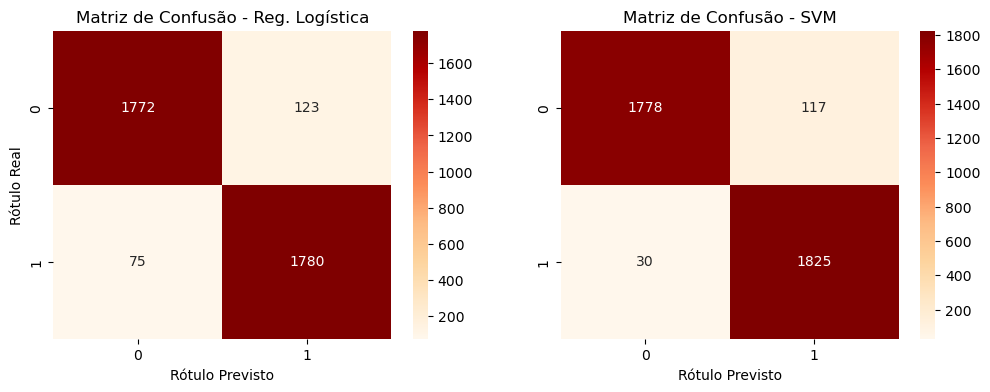

In [125]:
# Previsões
y_pred_reg = modelo_reg_2017.predict(X_test_2017_bin)
y_pred_svm = modelo_svm_2017.predict(X_test_2017_bin)

# Matriz de Confusão
conf_matrix_reg = confusion_matrix(y_test_2017_bin, y_pred_reg)
conf_matrix_svm = confusion_matrix(y_test_2017_bin, y_pred_svm)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(conf_matrix_reg, annot=True, cmap='OrRd', fmt='d', ax=axs[0])
axs[0].set_title('Matriz de Confusão - Reg. Logística')
sns.heatmap(conf_matrix_svm, annot=True, cmap='OrRd', fmt='d', ax=axs[1])
axs[1].set_title('Matriz de Confusão - SVM')

axs[0].set_xlabel('Rótulo Previsto')
axs[0].set_ylabel('Rótulo Real')
axs[1].set_xlabel('Rótulo Previsto')
plt.show()

##### Curva ROC

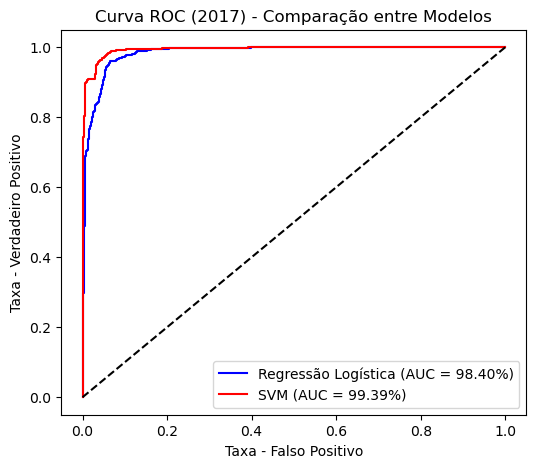

In [127]:
# Probabilidades (ROC e Precision-Recall Curve)
y_prob_reg = modelo_reg_2017.predict_proba(X_test_2017_bin)[:, 1]
y_prob_svm = modelo_svm_2017.decision_function(X_test_2017_bin)  # SVM usa decision_function

# Curva ROC - REG
fp_rate_reg, tp_rate_reg, _ = roc_curve(y_test_2017_bin, y_prob_reg)
roc_auc_reg = auc(fp_rate_reg, tp_rate_reg)

# Curva ROC - SVM
fp_rate_svm, tp_rate_svm, _ = roc_curve(y_test_2017_bin, y_prob_svm)
roc_auc_svm = auc(fp_rate_svm, tp_rate_svm)

plt.figure(figsize=(6, 5))
plt.plot(fp_rate_reg, tp_rate_reg, label=f'Regressão Logística (AUC = {roc_auc_reg:.2%})', color="Blue")
plt.plot(fp_rate_svm, tp_rate_svm, label=f'SVM (AUC = {roc_auc_svm:.2%})', color="Red")

plt.plot([0, 1], [0, 1], linestyle='--', color="black")

plt.xlabel('Taxa - Falso Positivo')
plt.ylabel('Taxa - Verdadeiro Positivo')
plt.title('Curva ROC (2017) - Comparação entre Modelos')
plt.legend()
plt.show()

##### Curva Precision-Recall

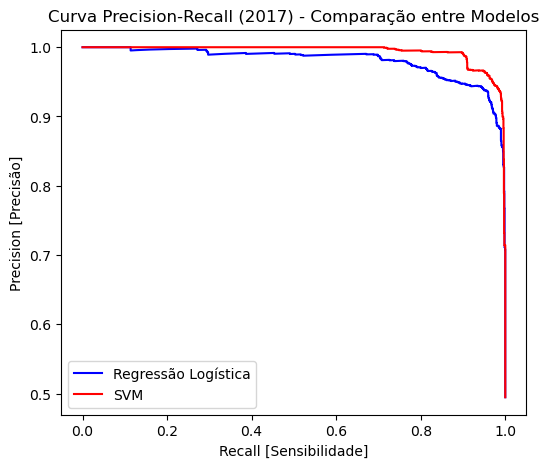

In [129]:
# Curva Precision-Recall
precision_reg, recall_reg, _ = precision_recall_curve(y_test_2017_bin, y_prob_reg)
precision_svm, recall_svm, _ = precision_recall_curve(y_test_2017_bin, y_prob_svm)

plt.figure(figsize=(6, 5))
plt.plot(recall_reg, precision_reg, label='Regressão Logística', color="Blue")
plt.plot(recall_svm, precision_svm, label='SVM', color="Red")
plt.xlabel('Recall [Sensibilidade]')
plt.ylabel('Precision [Precisão]')
plt.title('Curva Precision-Recall (2017) - Comparação entre Modelos')
plt.legend()
plt.show()

##### Relatório de Classificação

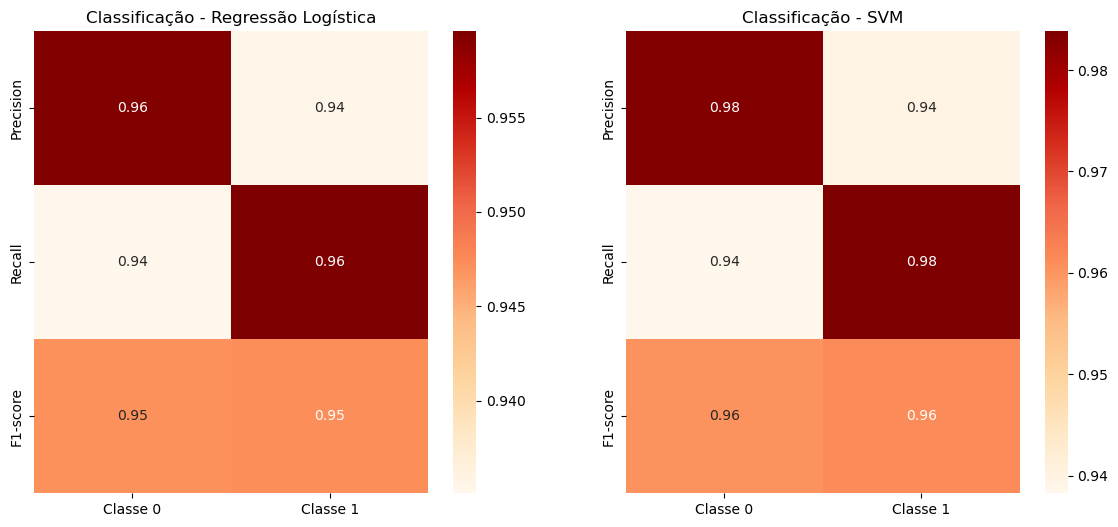

In [131]:
# Relatório de Classificação
target_names = ['Classe 0', 'Classe 1']
report_reg = classification_report(y_test_2017_bin, y_pred_reg, target_names=target_names, output_dict=True)
report_svm = classification_report(y_test_2017_bin, y_pred_svm, target_names=target_names, output_dict=True)

# Regressão Logísitica
precision_reg = [report_reg[cls]['precision'] for cls in target_names]
recall_reg = [report_reg[cls]['recall'] for cls in target_names]
f1_reg = [report_reg[cls]['f1-score'] for cls in target_names]

# Suport Vector Machine (SVM)
precision_svm = [report_svm[cls]['precision'] for cls in target_names]
recall_svm = [report_svm[cls]['recall'] for cls in target_names]
f1_svm = [report_svm[cls]['f1-score'] for cls in target_names]

data_reg = np.array([precision_reg, recall_reg, f1_reg])
data_svm = np.array([precision_svm, recall_svm, f1_svm])

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(data_reg, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[0], cmap='OrRd')
axs[0].set_title('Classificação - Regressão Logística')

sns.heatmap(data_svm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[1], cmap='OrRd')
axs[1].set_title('Classificação - SVM')
plt.show()

##### Acurácia

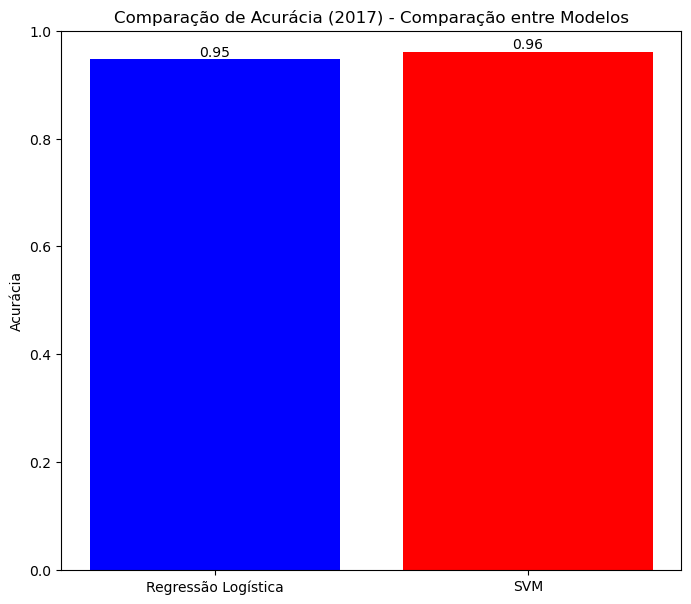

In [133]:
# Comparação de Acurácia
accuracy_reg = accuracy_score(y_test_2017_bin, y_pred_reg)
accuracy_svm = accuracy_score(y_test_2017_bin, y_pred_svm)

plt.figure(figsize=(8, 7))
bars = plt.bar(['Regressão Logística', 'SVM'], [accuracy_reg, accuracy_svm], color=['Blue', 'Red'])
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia (2017) - Comparação entre Modelos')
plt.ylim(0, 1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

#### Dados de 2018

##### Matriz de Confusão

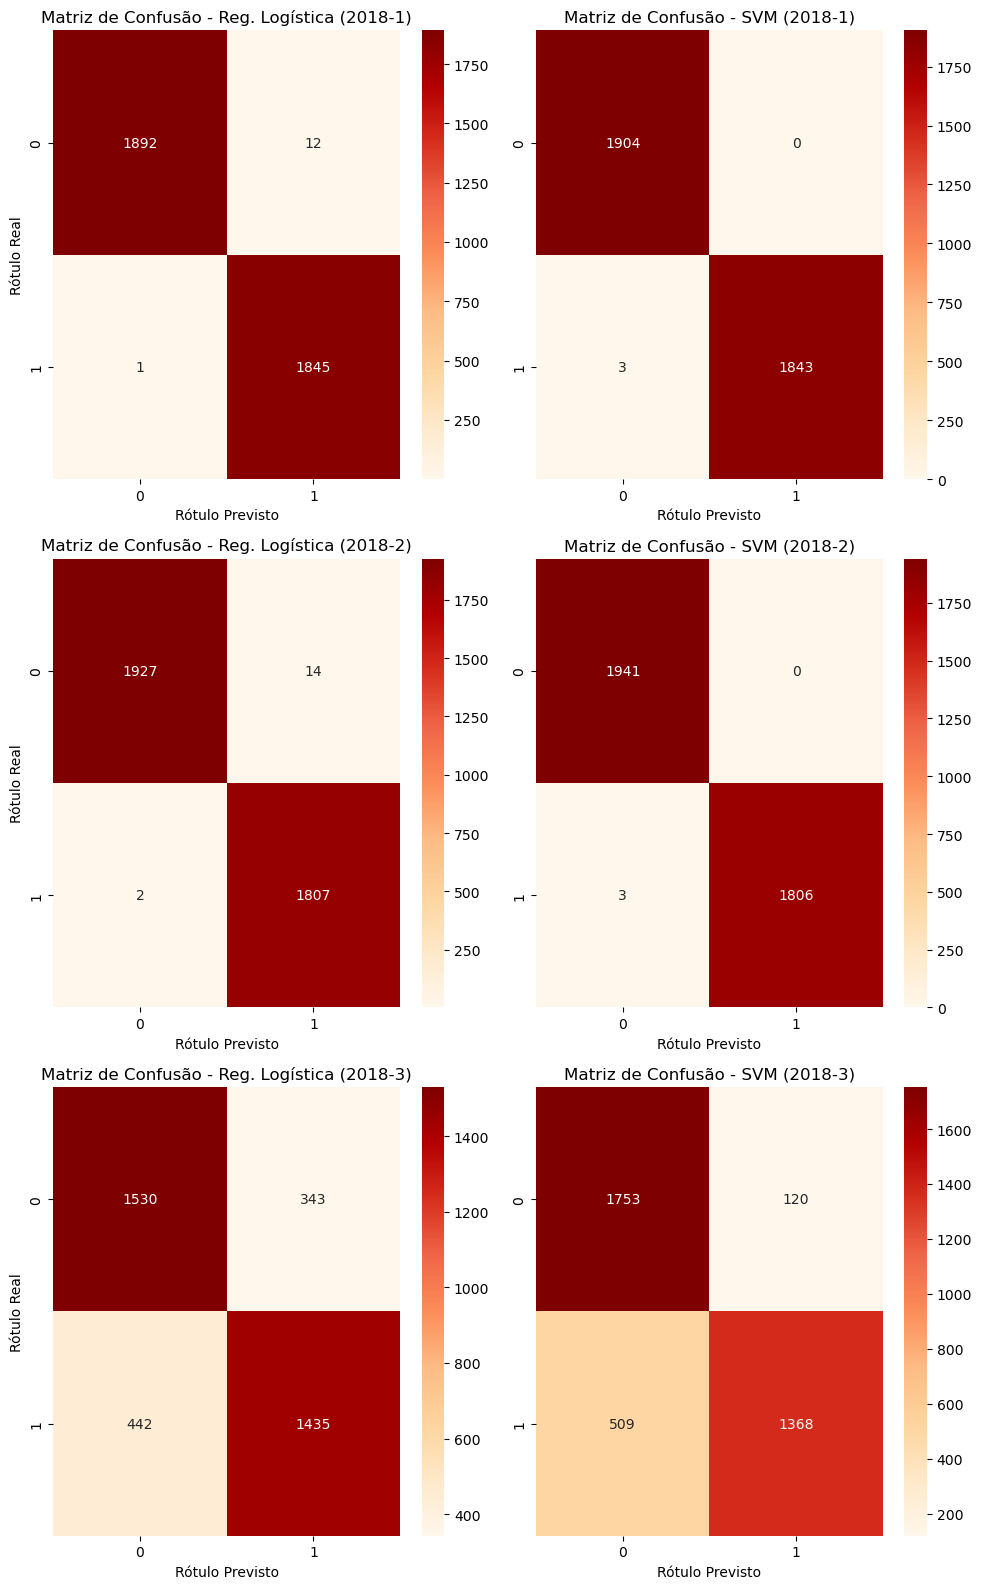

In [135]:
fig, axs = plt.subplots(3, 2, figsize=(10, 16))

datasets_binaria = [
    (X_test_2018_1_bin, y_test_2018_1_bin, modelo_reg_2018_1, modelo_svm_2018_1, "2018-1"),
    (X_test_2018_2_bin, y_test_2018_2_bin, modelo_reg_2018_2, modelo_svm_2018_2, "2018-2"),
    (X_test_2018_3_bin, y_test_2018_3_bin, modelo_reg_2018_3, modelo_svm_2018_3, "2018-3")
]

for i, (X_test, y_test, modelo_reg, modelo_svm, title) in enumerate(datasets_binaria):
    
    # Previsões para Regressão Logística e SVM
    y_pred_reg = modelo_reg.predict(X_test)
    y_pred_svm = modelo_svm.predict(X_test)

    # Matrizes de Confusão
    conf_matrix_reg = confusion_matrix(y_test, y_pred_reg)
    conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

    sns.heatmap(conf_matrix_reg, annot=True, cmap='OrRd', fmt='d', ax=axs[i, 0])
    axs[i, 0].set_title(f'Matriz de Confusão - Reg. Logística ({title})')

    sns.heatmap(conf_matrix_svm, annot=True, cmap='OrRd', fmt='d', ax=axs[i, 1])
    axs[i, 1].set_title(f'Matriz de Confusão - SVM ({title})')

    axs[i, 0].set_xlabel('Rótulo Previsto')
    axs[i, 0].set_ylabel('Rótulo Real')
    axs[i, 1].set_xlabel('Rótulo Previsto')

plt.tight_layout()
plt.show()

##### Curva ROC

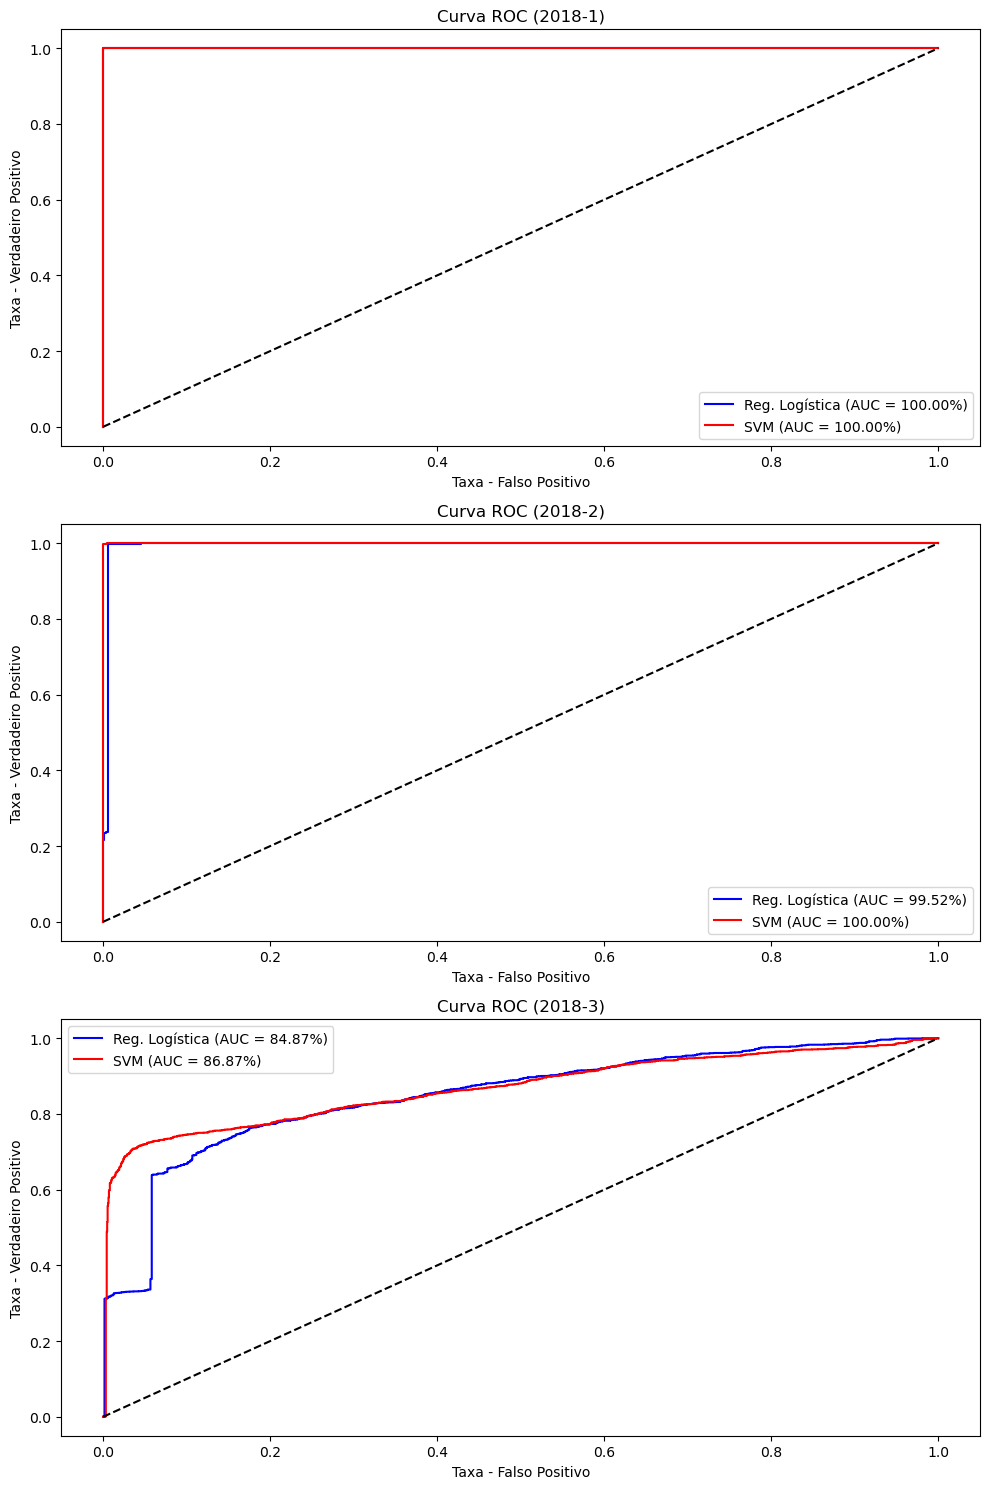

In [137]:
fig, axs = plt.subplots(3, 1, figsize=(10,15))

for i, (X_test, y_test, modelo_reg, modelo_svm, title) in enumerate(datasets_binaria):
    
    # Probabilidades
    y_prob_reg = modelo_reg.predict_proba(X_test)[:, 1]
    y_prob_svm = modelo_svm.decision_function(X_test)

    # Curva ROC - REG
    fp_rate_reg, tp_rate_reg, _ = roc_curve(y_test, y_prob_reg)
    roc_auc_reg = auc(fp_rate_reg, tp_rate_reg)

    # Curva ROC - SVM
    fp_rate_svm, tp_rate_svm, _ = roc_curve(y_test, y_prob_svm)
    roc_auc_svm = auc(fp_rate_svm, tp_rate_svm)

    axs[i].plot(fp_rate_reg, tp_rate_reg, label=f'Reg. Logística (AUC = {roc_auc_reg:.2%})', color='blue')
    axs[i].plot(fp_rate_svm, tp_rate_svm, label=f'SVM (AUC = {roc_auc_svm:.2%})', color='red')
    axs[i].plot([0, 1], [0, 1], linestyle='--', color='black')

    axs[i].set_xlabel('Taxa - Falso Positivo')
    axs[i].set_ylabel('Taxa - Verdadeiro Positivo')
    axs[i].set_title(f'Curva ROC ({title})')
    axs[i].legend()

plt.tight_layout()
plt.show()

##### Curva Precision-Recall

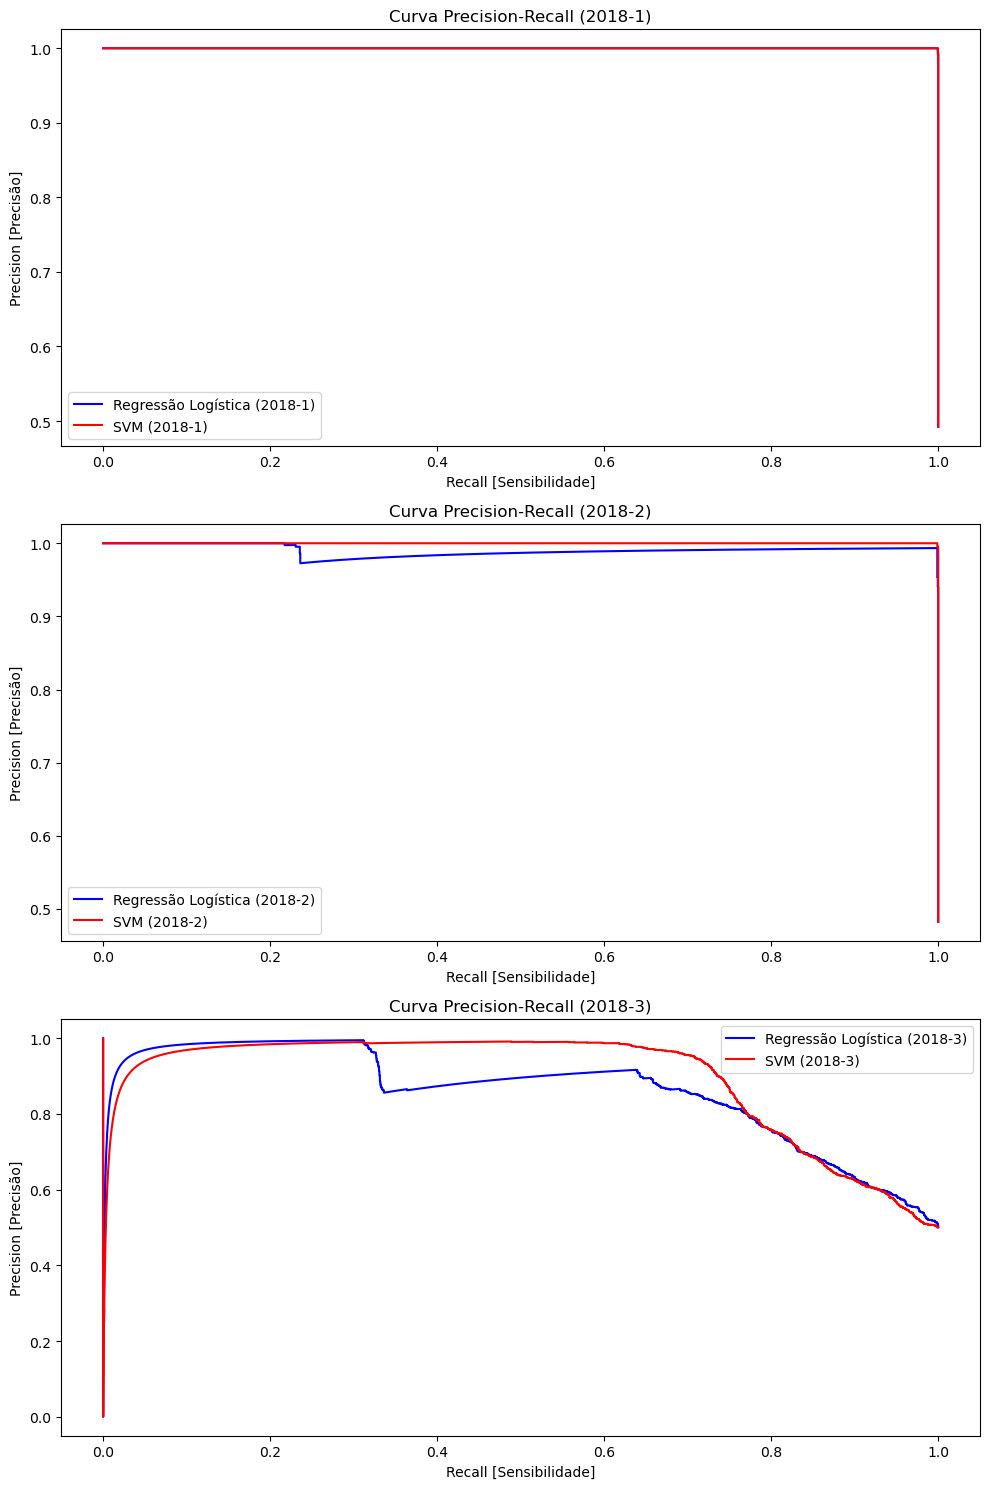

In [139]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, (X_test, y_test, modelo_reg, modelo_svm, title) in enumerate(datasets_binaria):

    # Probabilidades
    y_prob_reg = modelo_reg.predict_proba(X_test)[:, 1]
    y_prob_svm = modelo_svm.decision_function(X_test)

    # Curva Precision-Recall - REG
    precision_reg, recall_reg, _ = precision_recall_curve(y_test, y_prob_reg)

    # Curva Precision-Recall - SVM
    precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_prob_svm)

    axs[i].plot(recall_reg, precision_reg, label=f'Regressão Logística ({title})', color="Blue")
    axs[i].plot(recall_svm, precision_svm, label=f'SVM ({title})', color="Red")

    axs[i].set_xlabel('Recall [Sensibilidade]')
    axs[i].set_ylabel('Precision [Precisão]')
    axs[i].set_title(f'Curva Precision-Recall ({title})')
    axs[i].legend()

plt.tight_layout()
plt.show()

##### Relatório de Classificação

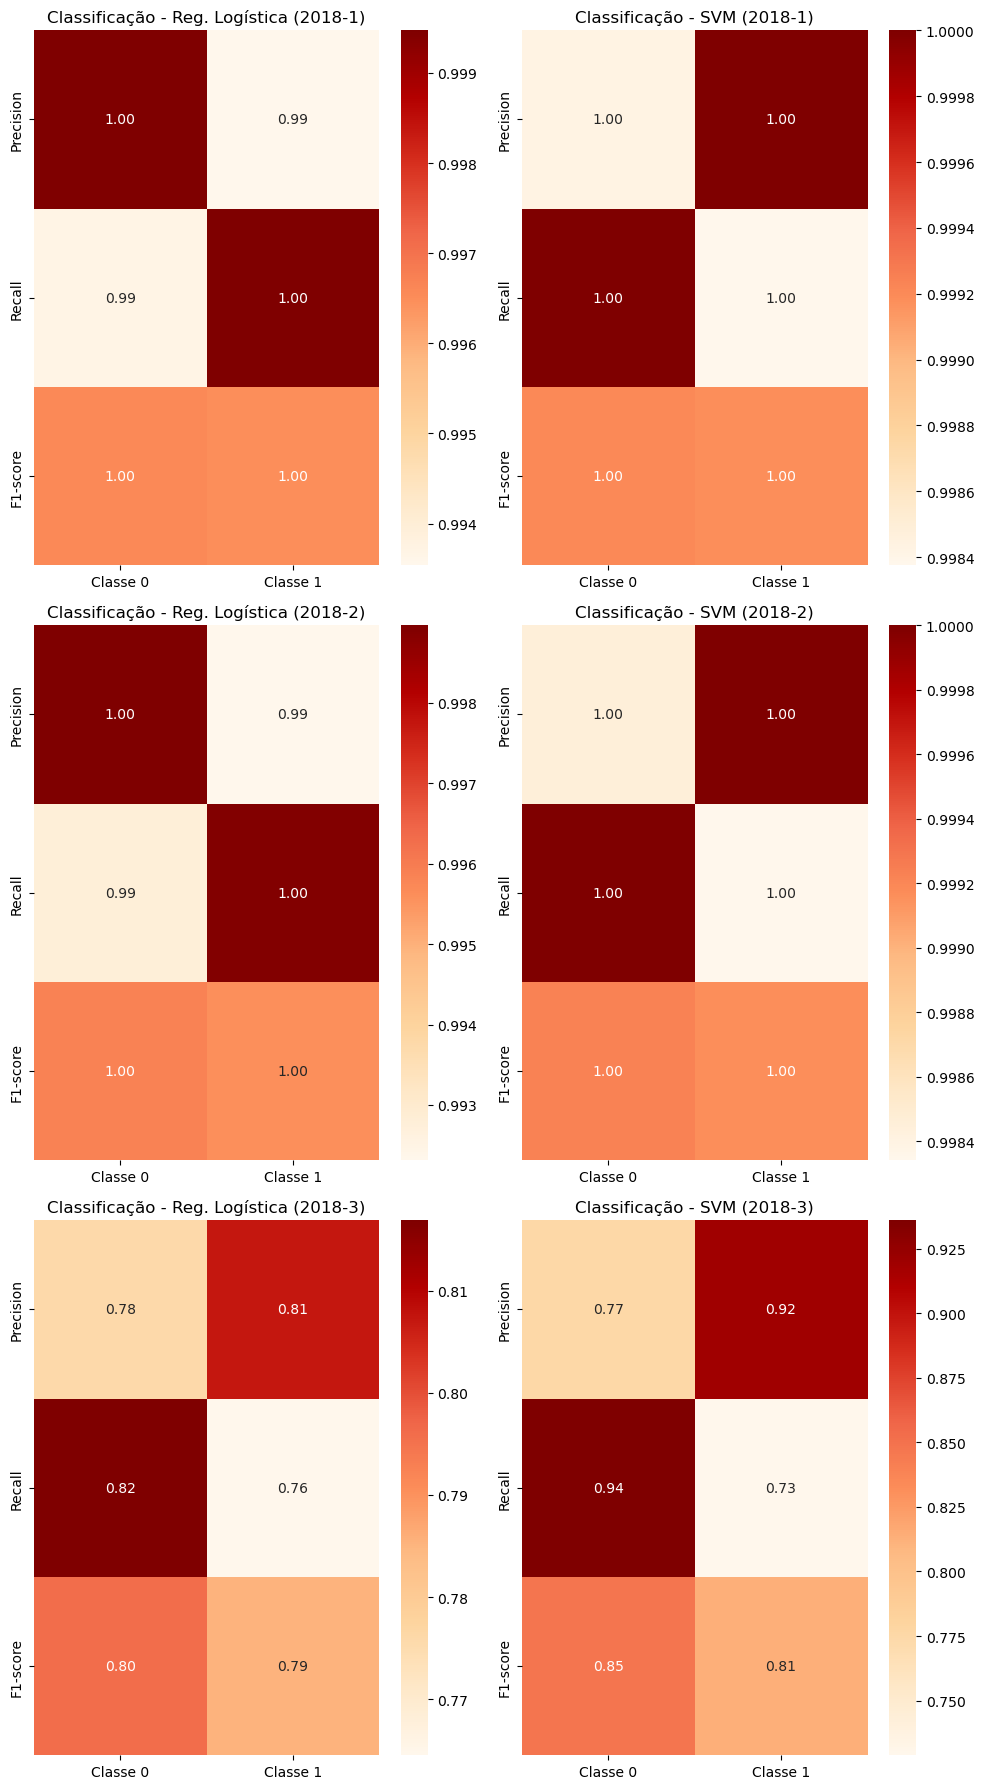

In [141]:
# Relatório de Classificação
fig, axs = plt.subplots(3, 2, figsize=(10, 18))

for i, (X_test, y_test, modelo_reg, modelo_svm, title) in enumerate(datasets_binaria):

    # Previsões
    y_pred_reg = modelo_reg.predict(X_test)
    y_pred_svm = modelo_svm.predict(X_test)

    # Relatório de Classificação
    target_names = ['Classe 0', 'Classe 1']
    report_reg = classification_report(y_test, y_pred_reg, target_names=target_names, output_dict=True)
    report_svm = classification_report(y_test, y_pred_svm, target_names=target_names, output_dict=True)

    # Regressão Logística
    precision_reg = [report_reg[cls]['precision'] for cls in target_names]
    recall_reg = [report_reg[cls]['recall'] for cls in target_names]
    f1_reg = [report_reg[cls]['f1-score'] for cls in target_names]

    # Suport Vector Machine (SVM)
    precision_svm = [report_svm[cls]['precision'] for cls in target_names]
    recall_svm = [report_svm[cls]['recall'] for cls in target_names]
    f1_svm = [report_svm[cls]['f1-score'] for cls in target_names]

    data_reg = np.array([precision_reg, recall_reg, f1_reg])
    data_svm = np.array([precision_svm, recall_svm, f1_svm])

    sns.heatmap(data_reg, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[i, 0], cmap='OrRd')
    axs[i, 0].set_title(f'Classificação - Reg. Logística ({title})')

    sns.heatmap(data_svm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[i, 1], cmap='OrRd')
    axs[i, 1].set_title(f'Classificação - SVM ({title})')

plt.tight_layout()
plt.show()

##### Acurácia

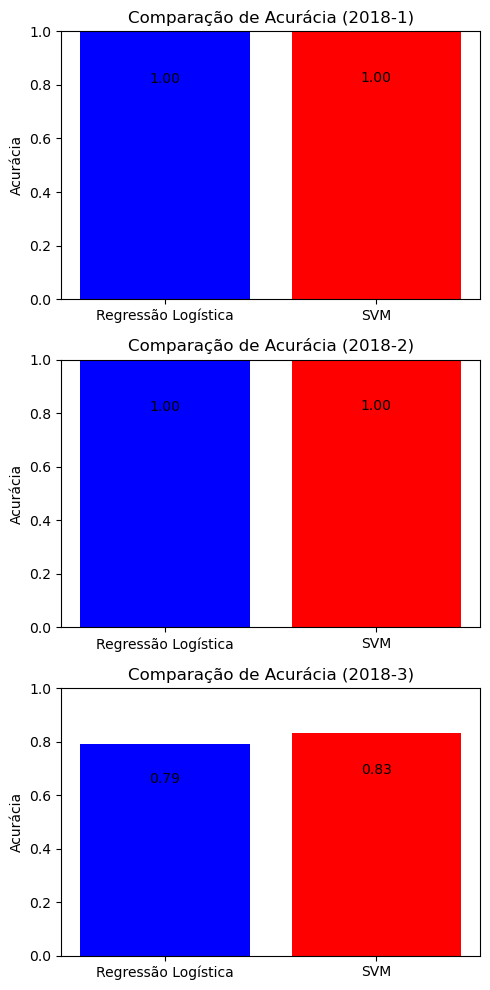

In [143]:
fig, axs = plt.subplots(3, 1, figsize=(5, 10))

for i, (X_test, y_test, modelo_reg, modelo_svm, title) in enumerate(datasets_binaria):
    
    # Previsões
    y_pred_reg = modelo_reg.predict(X_test)
    y_pred_svm = modelo_svm.predict(X_test)

    # Cálculo da acurácia
    accuracy_reg = accuracy_score(y_test, y_pred_reg)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)

    # Gráfico de barras
    bars = axs[i].bar(['Regressão Logística', 'SVM'], [accuracy_reg, accuracy_svm], color=['Blue', 'Red'])
    axs[i].set_ylabel('Acurácia')
    axs[i].set_title(f'Comparação de Acurácia ({title})')
    axs[i].set_ylim(0, 1)

    # Adicionar os valores das acurácias em cima das barras
    for bar in bars:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width() / 2, yval * 0.8, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Classificação Multi-classe ✅

#### Dados de 2017

##### Matriz de Confusão

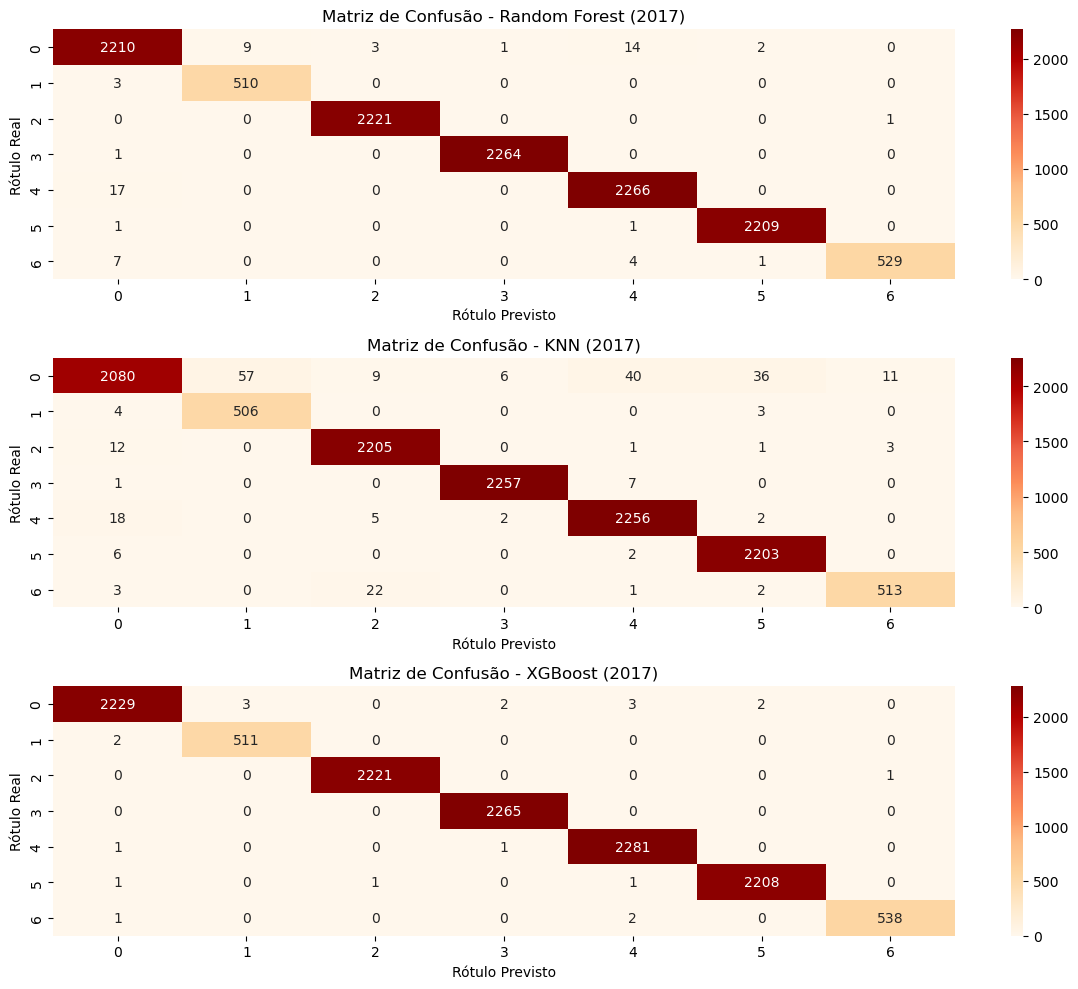

In [167]:
# Previsões
y_pred_rf_2017 = modelo_rf_2017.predict(X_test_2017_multi)
y_pred_knn_2017 = modelo_knn_2017.predict(X_test_2017_multi)
y_pred_xgb_2017 = modelo_xgb_2017.predict(X_test_2017_multi)

# Matrizes de Confusão
conf_matrix_rf_2017 = confusion_matrix(y_test_2017_multi, y_pred_rf_2017)
conf_matrix_knn_2017 = confusion_matrix(y_test_2017_multi, y_pred_knn_2017)
conf_matrix_xgb_2017 = confusion_matrix(y_test_2017_multi_enc, y_pred_xgb_2017)

fig, axs = plt.subplots(3, 1, figsize=(12, 10))

sns.heatmap(conf_matrix_rf_2017, annot=True, cmap='OrRd', fmt='d', ax=axs[0])
axs[0].set_title('Matriz de Confusão - Random Forest (2017)')
axs[0].set_xlabel('Rótulo Previsto')
axs[0].set_ylabel('Rótulo Real')

sns.heatmap(conf_matrix_knn_2017, annot=True, cmap='OrRd', fmt='d', ax=axs[1])
axs[1].set_title('Matriz de Confusão - KNN (2017)')
axs[1].set_xlabel('Rótulo Previsto')
axs[1].set_ylabel('Rótulo Real')

sns.heatmap(conf_matrix_xgb_2017, annot=True, cmap='OrRd', fmt='d', ax=axs[2])
axs[2].set_title('Matriz de Confusão - XGBoost (2017)')
axs[2].set_xlabel('Rótulo Previsto')
axs[2].set_ylabel('Rótulo Real')

plt.tight_layout()
plt.show()

##### Relatório de Classificação

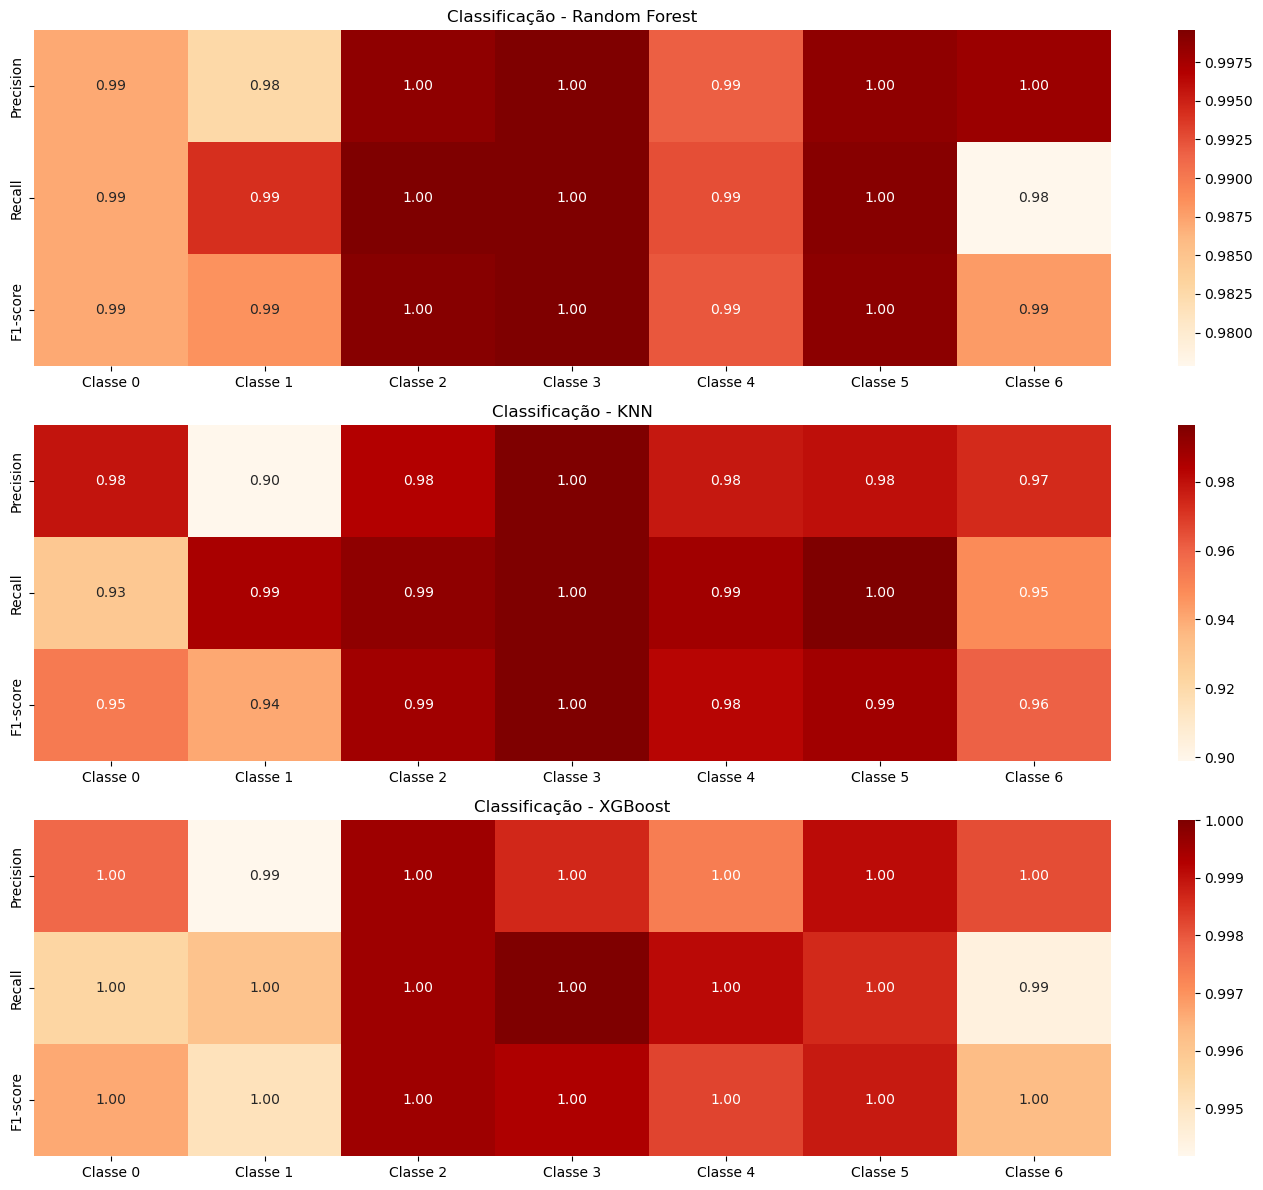

In [179]:
# Relatório de Classificação
target_names = [f'Classe {i}' for i in range(7)]

report_rf_2017 = classification_report(y_test_2017_multi, y_pred_rf_2017, target_names=target_names, output_dict=True)
report_knn_2017 = classification_report(y_test_2017_multi, y_pred_knn_2017, target_names=target_names, output_dict=True)
report_xgb_2017 = classification_report(y_test_2017_multi_enc, y_pred_xgb_2017, target_names=target_names, output_dict=True)

# Random Forest
precision_rf = [report_rf_2017[cls]['precision'] for cls in target_names]
recall_rf = [report_rf_2017[cls]['recall'] for cls in target_names]
f1_rf = [report_rf_2017[cls]['f1-score'] for cls in target_names]

# KNN
precision_knn = [report_knn_2017[cls]['precision'] for cls in target_names]
recall_knn = [report_knn_2017[cls]['recall'] for cls in target_names]
f1_knn = [report_knn_2017[cls]['f1-score'] for cls in target_names]

# XGBoost
precision_xgb = [report_xgb_2017[cls]['precision'] for cls in target_names]
recall_xgb = [report_xgb_2017[cls]['recall'] for cls in target_names]
f1_xgb = [report_xgb_2017[cls]['f1-score'] for cls in target_names]

# Organizando os dados em formato de matriz para visualização
data_rf = np.array([precision_rf, recall_rf, f1_rf])
data_knn = np.array([precision_knn, recall_knn, f1_knn])
data_xgb = np.array([precision_xgb, recall_xgb, f1_xgb])

fig, axs = plt.subplots(3, 1, figsize=(14, 12))

# Random Forest
sns.heatmap(data_rf, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[0], cmap='OrRd')
axs[0].set_title('Classificação - Random Forest')

# KNN
sns.heatmap(data_knn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[1], cmap='OrRd')
axs[1].set_title('Classificação - KNN')

# XGBoost
sns.heatmap(data_xgb, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[2], cmap='OrRd')
axs[2].set_title('Classificação - XGBoost')

plt.tight_layout()
plt.show()

##### Acurácia

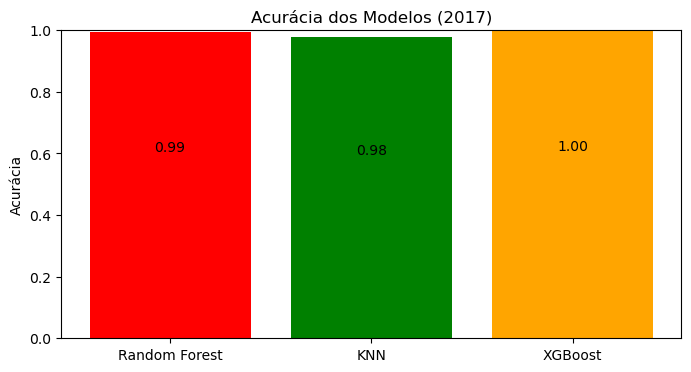

In [183]:
# Comparação de Acurácia
accuracy_rf_2017 = accuracy_score(y_test_2017_multi, y_pred_rf_2017)
accuracy_knn_2017 = accuracy_score(y_test_2017_multi, y_pred_knn_2017)
accuracy_xgb_2017 = accuracy_score(y_test_2017_multi_enc, y_pred_xgb_2017)

plt.figure(figsize=(8, 4))
models = ['Random Forest', 'KNN', 'XGBoost']
accuracies = [accuracy_rf_2017, accuracy_knn_2017, accuracy_xgb_2017]
bars = plt.bar(models, accuracies, color=['red', 'green', 'orange'])

# Adicionar os valores da acurácia em cima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval * 0.6, f'{yval:.2f}', ha='center', va='bottom')

plt.ylabel('Acurácia')
plt.title('Acurácia dos Modelos (2017)')
plt.ylim(0, 1)
plt.show()

#### Dados de 2018

##### Matriz de Confusão

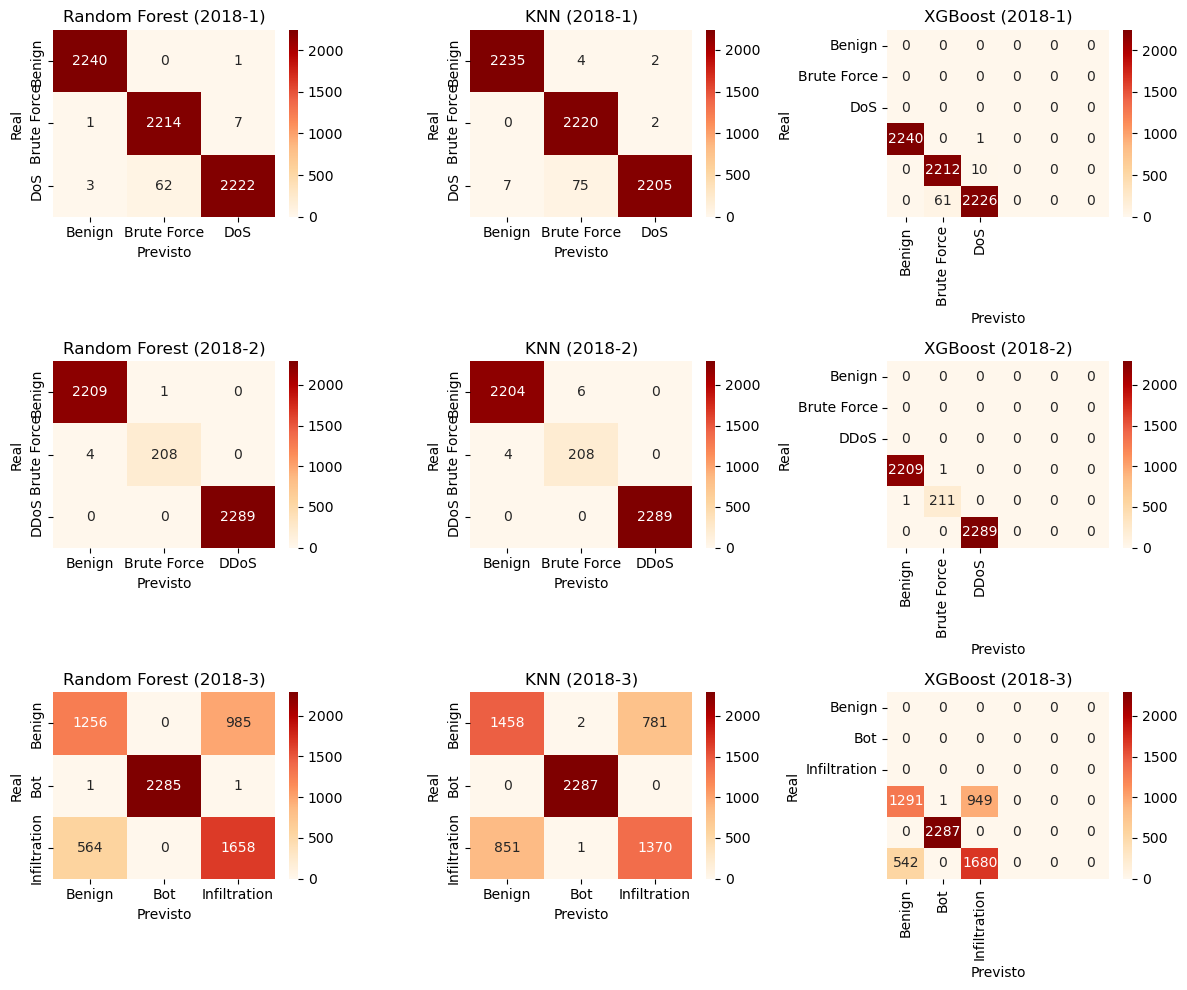

In [217]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

datasets_multiclasse = [
    (X_test_2018_1_multi, y_test_2018_1_multi, modelo_rf_2018_1, modelo_knn_2018_1, modelo_xgb_2018_1, "2018-1"),
    (X_test_2018_2_multi, y_test_2018_2_multi, modelo_rf_2018_2, modelo_knn_2018_2, modelo_xgb_2018_2, "2018-2"),
    (X_test_2018_3_multi, y_test_2018_3_multi, modelo_rf_2018_3, modelo_knn_2018_3, modelo_xgb_2018_3, "2018-3"),
]

model_names = ["Random Forest", "KNN", "XGBoost"]

for i, (X_test, y_test, modelo_rf, modelo_knn, modelo_xgb, title) in enumerate(datasets_multiclasse):

    # Previsões
    y_pred_rf = modelo_rf.predict(X_test)
    y_pred_knn = modelo_knn.predict(X_test)
    y_pred_xgb = modelo_xgb.predict(X_test)

    y_test = [str(label) for label in y_test]
    y_pred_rf = [str(label) for label in y_pred_rf]
    y_pred_knn = [str(label) for label in y_pred_knn]
    y_pred_xgb = [str(label) for label in y_pred_xgb]

    preds = [y_pred_rf, y_pred_knn, y_pred_xgb]

    for j, (y_pred, model) in enumerate(zip(preds, model_names)):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), ax=axs[i, j])
        axs[i, j].set_title(f'{model} ({title})')
        axs[i, j].set_xlabel('Previsto')
        axs[i, j].set_ylabel('Real')

plt.tight_layout()
plt.show()

##### Relatório de Classificação

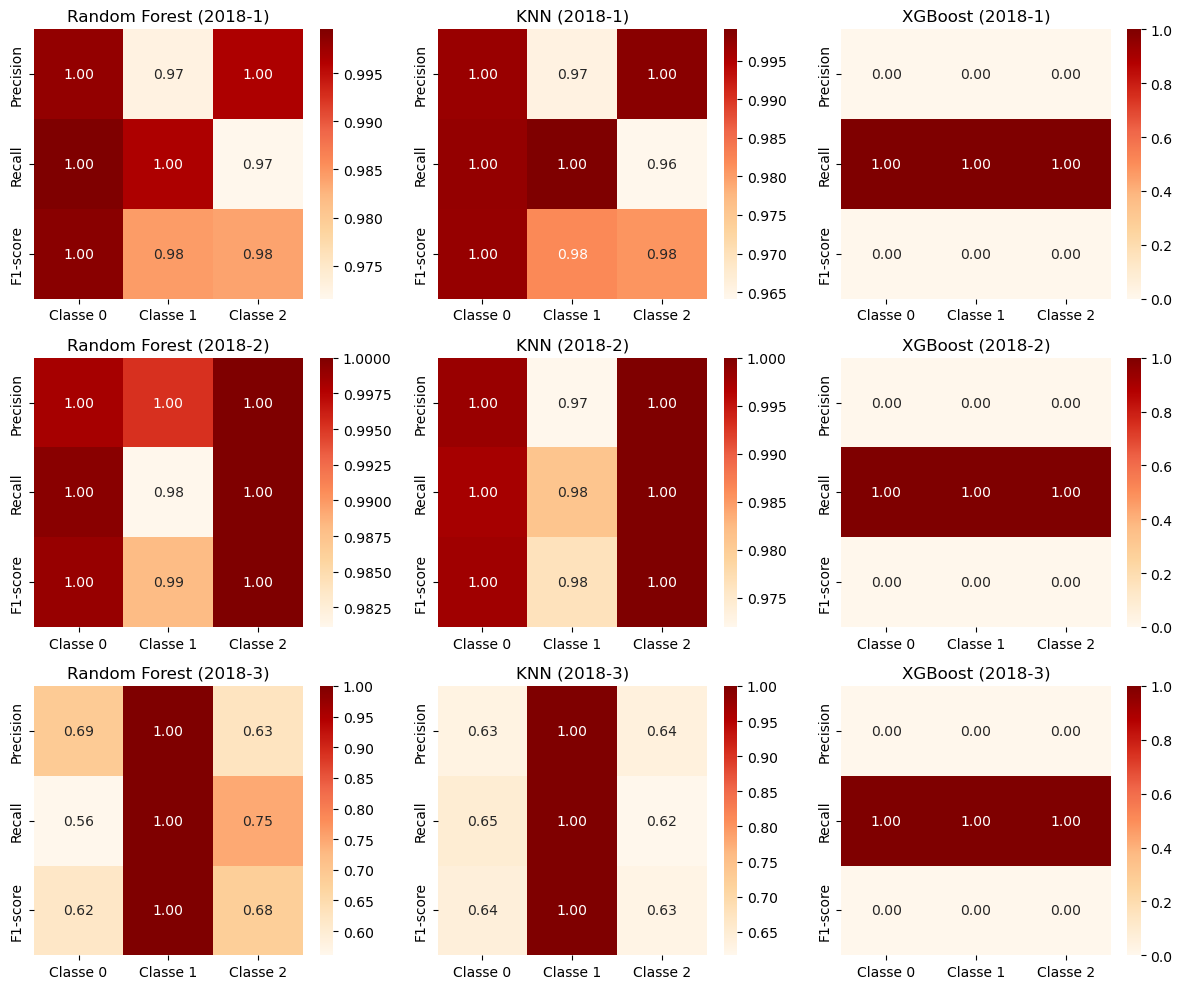

In [255]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

for i, (X_test, y_test, modelo_rf, modelo_knn, modelo_xgb, title) in enumerate(datasets_multiclasse):

    # Previsões para os modelos
    y_pred_rf = modelo_rf.predict(X_test)
    y_pred_knn = modelo_knn.predict(X_test)
    y_pred_xgb = modelo_xgb.predict(X_test)

    y_test = y_test.astype(str)
    y_pred_xgb = y_pred_xgb.astype(str)

    target_names = [f'Classe {i}' for i in range(3)]

    # Relatório de Classificação para Random Forest
    report_rf = classification_report(y_test, y_pred_rf, target_names=target_names, output_dict=True)
    report_knn = classification_report(y_test, y_pred_knn, target_names=target_names, output_dict=True)
    report_xgb = classification_report(y_test, y_pred_xgb, labels=unique_classes, target_names=[f'Classe {i}' for i in range(6)], output_dict=True, zero_division=1)


    # Extrair Precision, Recall, F1-score para Random Forest
    precision_rf = [report_rf[cls]['precision'] for cls in target_names]
    recall_rf = [report_rf[cls]['recall'] for cls in target_names]
    f1_rf = [report_rf[cls]['f1-score'] for cls in target_names]

    # Extrair Precision, Recall, F1-score para KNN
    precision_knn = [report_knn[cls]['precision'] for cls in target_names]
    recall_knn = [report_knn[cls]['recall'] for cls in target_names]
    f1_knn = [report_knn[cls]['f1-score'] for cls in target_names]

    # Extrair Precision, Recall, F1-score para XGBoost
    precision_xgb = [report_xgb[cls]['precision'] for cls in target_names]
    recall_xgb = [report_xgb[cls]['recall'] for cls in target_names]
    f1_xgb = [report_xgb[cls]['f1-score'] for cls in target_names]

    # Organizando as métricas em arrays
    data_rf = np.array([precision_rf, recall_rf, f1_rf])
    data_knn = np.array([precision_knn, recall_knn, f1_knn])
    data_xgb = np.array([precision_xgb, recall_xgb, f1_xgb])

    sns.heatmap(data_rf, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[i, 0], cmap='OrRd')
    axs[i, 0].set_title(f'Random Forest ({title})')

    sns.heatmap(data_knn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[i, 1], cmap='OrRd')
    axs[i, 1].set_title(f'KNN ({title})')

    sns.heatmap(data_xgb, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=['Precision', 'Recall', 'F1-score'], ax=axs[i, 2], cmap='OrRd')
    axs[i, 2].set_title(f'XGBoost ({title})')

plt.tight_layout()
plt.show()


##### Acurácia

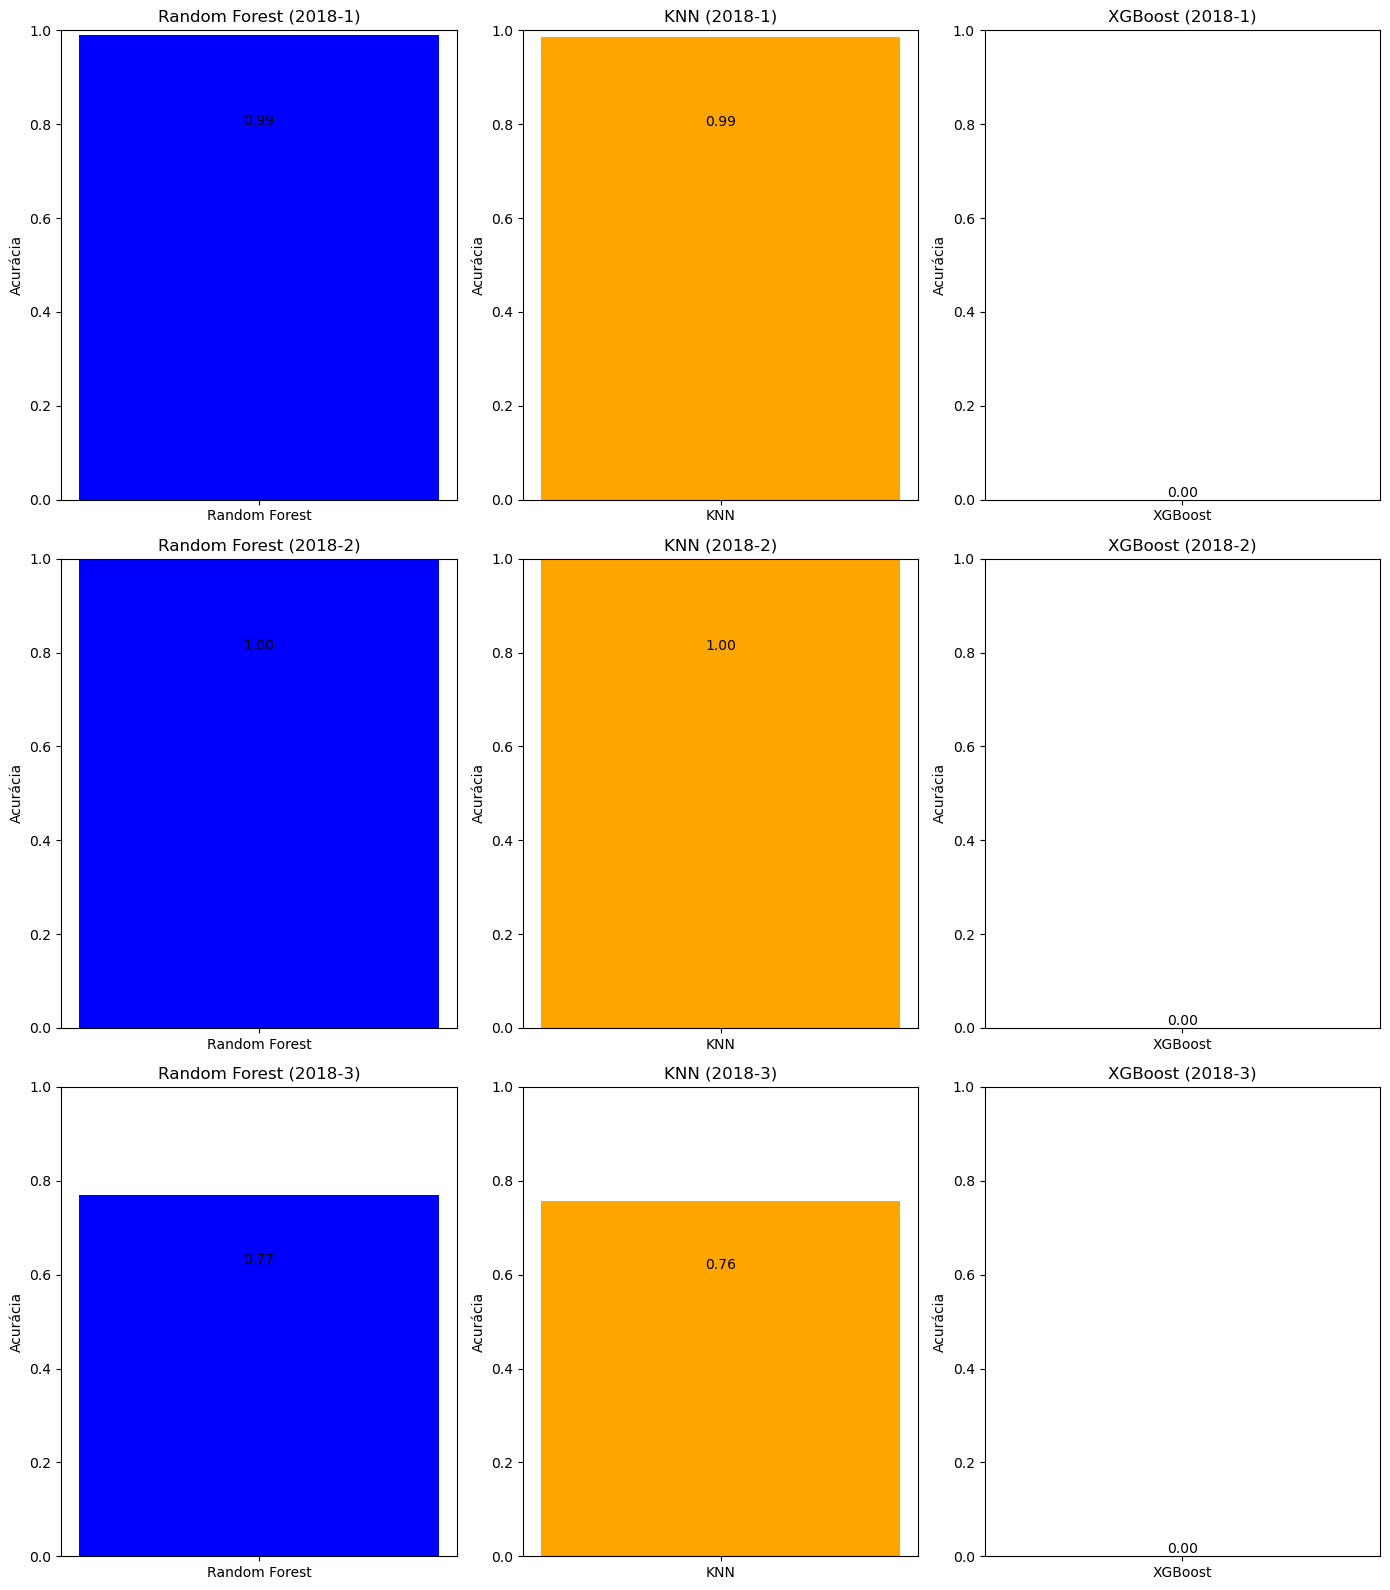

In [239]:
# Comparação de Acurácia
fig, axs = plt.subplots(3, 3, figsize=(14, 16)) 

for i, (X_test, y_test, modelo_rf, modelo_knn, modelo_xgb, title) in enumerate(datasets_multiclasse):
    
    # Previsões
    y_pred_rf = modelo_rf.predict(X_test)
    y_pred_knn = modelo_knn.predict(X_test)
    y_pred_xgb = modelo_xgb.predict(X_test)

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

    bars_rf = axs[i, 0].bar(['Random Forest'], [accuracy_rf], color='Blue')
    axs[i, 0].set_ylabel('Acurácia')
    axs[i, 0].set_title(f'Random Forest ({title})')
    axs[i, 0].set_ylim(0, 1)

    bars_knn = axs[i, 1].bar(['KNN'], [accuracy_knn], color='Orange')
    axs[i, 1].set_ylabel('Acurácia')
    axs[i, 1].set_title(f'KNN ({title})')
    axs[i, 1].set_ylim(0, 1)

    bars_xgb = axs[i, 2].bar(['XGBoost'], [accuracy_xgb], color='Red')
    axs[i, 2].set_ylabel('Acurácia')
    axs[i, 2].set_title(f'XGBoost ({title})')
    axs[i, 2].set_ylim(0, 1)

    axs[i, 0].text(bars_rf[0].get_x() + bars_rf[0].get_width() / 2, accuracy_rf * 0.8, f'{accuracy_rf:.2f}', ha='center', va='bottom')
    axs[i, 1].text(bars_knn[0].get_x() + bars_knn[0].get_width() / 2, accuracy_knn * 0.8, f'{accuracy_knn:.2f}', ha='center', va='bottom')
    axs[i, 2].text(bars_xgb[0].get_x() + bars_xgb[0].get_width() / 2, accuracy_xgb * 0.8, f'{accuracy_xgb:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Salvando modelos para aplicação em Interface

In [269]:
import joblib

# Dados para implementação no Streamlit
dados = {
    "X_2017_bin": X_2017_bin,
    "y_2017_bin": y_2017_bin,
    "colunas_2017_bin": df_2017_balanceado.columns.tolist(),
    "X_2017_scaled_bin": X_2017_bin_scaled,
    "X_train_2017_bin": X_train_2017_bin,
    "X_test_2017_bin": X_test_2017_bin,
    "y_train_2017_bin": y_train_2017_bin,
    "y_test_2017_bin": y_test_2017_bin,

    "X_2017_multi": X_2017_multi,
    "y_2017_multi": y_2017_multi,
    "colunas_2017_multi": df_2017_balanced.columns.tolist(),
    "X_2017_scaled_multi": X_2017_multi_scaled,
    "X_train_2017_multi": X_train_2017_multi,
    "X_test_2017_multi": X_test_2017_multi,
    "y_train_2017_multi": y_train_2017_multi,
    "y_test_2017_multi": y_test_2017_multi,

    "y_train_2017_multi_enc": y_train_2017_multi_enc,
    "y_test_2017_multi_enc": y_test_2017_multi_enc,

    "modelo_reg_2017": modelo_reg_2017,
    "modelo_svm_2017": modelo_svm_2017,
    "modelo_rf_2017": modelo_rf_2017,
    "modelo_knn_2017": modelo_knn_2017,
    "modelo_xgb_2017": modelo_xgb_2017,
}

joblib.dump(dados, "modelos.pkl")

print("Todas as variáveis e modelos foram salvos com sucesso!")

Todas as variáveis e modelos foram salvos com sucesso!
